# UK Traffic Accidents Severity Classification
4IZ565 – Programming for Data Science in Python

Spring Semester 2023/2024 Coursework

Authors: Terka Lukešová, Jan Štipl

## Dataset Description
The dataset contains statistics on traffic accidents in the UK, including many attributes, such as the route category and hazards, the vehicles involved, and some information about the drivers. Our goal will be to predict the target attribute Accident Severity, whose values are Slight/Serious/Fatal.

Dataset source: https://www.kaggle.com/datasets/tsiaras/uk-road-safety-accidents-and-vehicles

## Exploratory Data Analysis

### Initial settings

In [1]:
import gc
import random
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sklearn.set_config(transform_output="pandas")

RANDOM_STATE = 42  # used throughout the notebook to make the results reproducible
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

### Load CSV tables and merge them 

In [2]:
# For speed during testing load only small percentage of the data
p = 0.05  # 5% of the lines
skip_rows = lambda i: i > 0 and random.random() > p
# skip_rows = None

accidents_df = pd.read_csv("./data/Accident_Information.csv", skiprows=skip_rows, low_memory=False)
# UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 3169: invalid start byte
vehicle_df = pd.read_csv("./data/Vehicle_Information.csv", encoding="latin1", low_memory=False)

In [3]:
df = pd.merge(accidents_df, vehicle_df, on="Accident_Index", how="inner")
del vehicle_df
del accidents_df

### Overview

In [4]:
df

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year_x,InScotland,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,make,model,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year_y
0,200501BS00002,B,450,C,0.000,Slight,NaN,2005-01-05,Wednesday,1.000,Auto traffic signal,Crossroads,51.520,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524170.000,181650.000,-0.212,E01002909,1,1,0.000,5.000,Metropolitan Police,Dry,Dual carriageway,NaN,30.000,17:36,Urban,Fine no high winds,2005,No,36 - 45,3.000,Data missing or out of range,NaN,8268.000,NaN,NaN,Journey as part of work,Leaving roundabout,DENNIS,NaN,Heavy oil,Male,NaN,No tow/articulation,Did not leave carriageway,0.000,Slowing or stopping,1,Bus or coach (17 or more pass seats),No,Nearside,2005
1,200501BS00022,A,4,Unclassified,0.000,Serious,NaN,2005-01-08,Saturday,1.000,Give way or uncontrolled,T or staggered junction,51.495,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,526790.000,178980.000,-0.175,E01002821,1,1,0.000,0.000,Metropolitan Police,Dry,Single carriageway,NaN,30.000,03:00,Urban,Fine no high winds,2005,No,26 - 35,1.000,Urban area,6.000,1997.000,NaN,NaN,Other/Not known (2005-10),Approaching junction or waiting/parked at junc...,HONDA,ACCORD VTEC SPORT,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.000,Going ahead other,1,Car,No,Front,2005
2,200501BS70014,B,302,Unclassified,0.000,Slight,NaN,2005-02-07,Monday,1.000,Give way or uncontrolled,T or staggered junction,51.484,Daylight,Kensington and Chelsea,Kensington and Chelsea,527570.000,177720.000,-0.164,E01002900,1,2,0.000,0.000,Metropolitan Police,Dry,Single carriageway,NaN,30.000,09:15,Urban,Fine no high winds,2005,No,36 - 45,3.000,Urban area,8.000,599.000,NaN,NaN,Other/Not known (2005-10),Mid Junction - on roundabout or on main road,HONDA,CB 600 F-2,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.000,Turning left,1,Motorcycle over 500cc,No,Front,2005
3,200501BS70070,B,412,Unclassified,0.000,Slight,NaN,2005-03-08,Tuesday,1.000,Auto traffic signal,Crossroads,51.517,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524590.000,181280.000,-0.206,E01002831,1,1,0.000,0.000,Metropolitan Police,Dry,Single carriageway,NaN,30.000,23:40,Urban,Fine no high winds,2005,No,36 - 45,2.000,Urban area,3.000,1997.000,NaN,NaN,Other/Not known (2005-10),Mid Junction - on roundabout or on main road,PEUGEOT,406 GLX HDI (110),Heavy oil,Male,NaN,No tow/articulation,Did not leave carriageway,0.000,Going ahead other,1,Car,No,Front,2005
4,200501BS70083,B,450,NaN,0.000,Slight,NaN,2005-03-17,Thursday,1.000,Data missing or out of range,Not at junction or within 20 metres,51.517,Daylight,Kensington and Chelsea,Kensington and Chelsea,524290.000,181340.000,-0.210,E01002831,1,1,0.000,4.000,Metropolitan Police,Dry,Single carriageway,NaN,30.000,09:15,Urban,Fine no high winds,2005,No,21 - 25,1.000,Data missing or out of range,NaN,1360.000,NaN,NaN,Other/Not known (2005-10),Not at or within 20 metres of junction,PEUGEOT,206 S,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.000,Goi

In [5]:
df.info(memory_usage='deep', show_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103463 entries, 0 to 103462
Data columns (total 57 columns):
 #   Column                                       Dtype  
---  ------                                       -----  
 0   Accident_Index                               object 
 1   1st_Road_Class                               object 
 2   1st_Road_Number                              int64  
 3   2nd_Road_Class                               object 
 4   2nd_Road_Number                              float64
 5   Accident_Severity                            object 
 6   Carriageway_Hazards                          object 
 7   Date                                         object 
 8   Day_of_Week                                  object 
 9   Did_Police_Officer_Attend_Scene_of_Accident  float64
 10  Junction_Control                             object 
 11  Junction_Detail                              object 
 12  Latitude                                     float64
 13  Light_Conditio

In [6]:
df.describe()

,1st_Road_Number,2nd_Road_Number,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Speed_limit,Year_x,Age_of_Vehicle,Driver_IMD_Decile,Engine_Capacity_.CC.,Vehicle_Location.Restricted_Lane,Vehicle_Reference,Year_y
count,103463.000,102509.000,103458.000,103459.000,103459.000,103459.000,103459.000,103463.000,103463.000,103434.000,103401.000,103460.000,103463.000,86568.000,68837.000,91003.000,103397.000,103463.000,103463.000
mean,986.121,373.572,1.176,52.538,443156.137,294486.236,-1.385,1.453,2.126,0.009,0.716,39.758,2011.337,7.135,5.406,2025.487,0.103,1.554,2011.337
std,1798.271,1278.812,0.389,1.429,94937.444,158706.661,1.394,1.103,0.873,0.124,1.803,14.619,3.392,4.776,2.819,1899.455,0.861,0.736,3.392
min,0.000,0.000,1.000,49.915,83800.000,10566.000,-7.284,1.000,1.000,0.000,0.000,10.000,2005.000,1.000,1.000,6.000,0.000,1.000,2005.000
25%,0.000,0.000,1.000,51.482,381520.000,177240.000,-2.277,1.000,2.000,0.000,0.000,30.000,2009.000,3.000,3.000,1299.000,0.000,1.000,2009.000
50%,127.000,0.000,1.000,52.203,444510.000,257790.000,-1.341,1.000,2.000,0.000,0.000,30.000,2012.000,7.000,5.000,1598.000,0.000,1.000,2012.000
75%,689.000,0.000,1.000,53.443,524360.000,394292.000,-0.204,2.000,2.000,0.000,0.000,50.000,2014.000,10.000,8.000,1997.000,0.000,2.000,2014.000
max,9999.000,9999.000,3.000,60.443,655131.000,1173530.000,1.756,87.000,12.000,2.000,8.000,70.000,2016.000,91.000,10.000,73000.000,9.000,12.000,2016.000


In [7]:
df.select_dtypes(exclude='number').nunique() # Count unique values in each non-numerical column

Accident_Index                 69656
1st_Road_Class                     6
2nd_Road_Class                     6
Accident_Severity                  3
Carriageway_Hazards                6
Date                            4382
Day_of_Week                        7
Junction_Control                   6
Junction_Detail                   10
Light_Conditions                   6
Local_Authority_(District)       416
Local_Authority_(Highway)        207
LSOA_of_Accident_Location      23506
Police_Force                      51
Road_Surface_Conditions            6
Road_Type                          6
Special_Conditions_at_Site         8
Time                            1428
Urban_or_Rural_Area                3
Weather_Conditions                10
InScotland                         2
Age_Band_of_Driver                12
Driver_Home_Area_Type              4
Hit_Object_in_Carriageway         12
Hit_Object_off_Carriageway        12
Journey_Purpose_of_Driver          8
Junction_Location                 10
m

In [8]:
target_variable = 'Accident_Severity'
df[target_variable] = df[target_variable].astype('category')

### Do the Number of Casualties and Number of Vehicles correlate with Accident Severity?

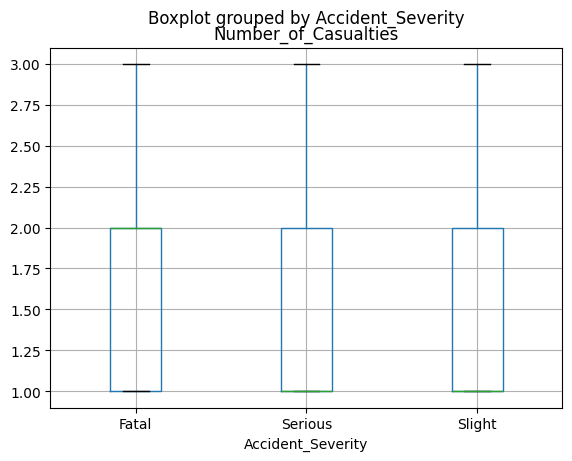

In [9]:
df.boxplot('Number_of_Casualties', by=target_variable, showfliers=False)
plt.show()

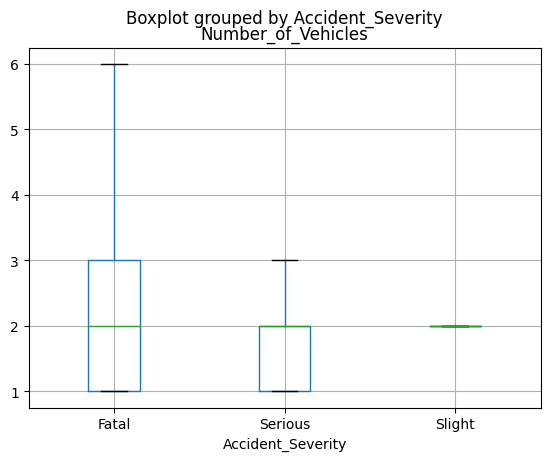

In [10]:
df.boxplot('Number_of_Vehicles', by=target_variable, showfliers=False)
plt.show()

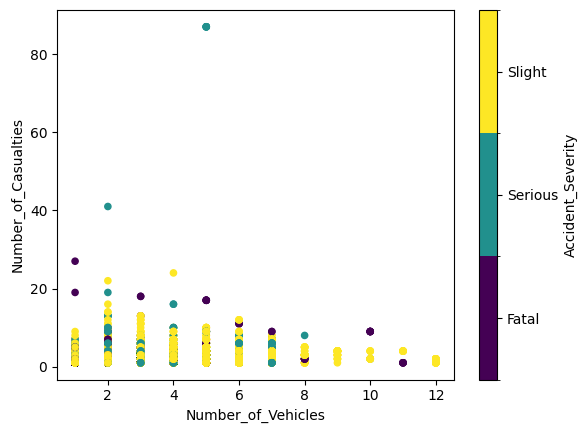

In [11]:
df.plot.scatter('Number_of_Vehicles', 'Number_of_Casualties', c=target_variable, cmap='viridis')
plt.show()

### Problems
* Categorical values and not one-hot encoded
* The DataFrame occupies more than 250 MB of RAM due to string repetition (and we load only 5% of the rows!)
* String values, such as 'Unclassified', and np.nan reside the same columns -> we have to merge them

In [12]:
df['Carriageway_Hazards'].unique()

array([nan, 'Previous accident',
       'Any animal in carriageway (except ridden horse)',
       'Other object on road', 'Pedestrian in carriageway - not injured',
       'Vehicle load on road', 'Data missing or out of range'],
      dtype=object)

* The classes are very imbalanced

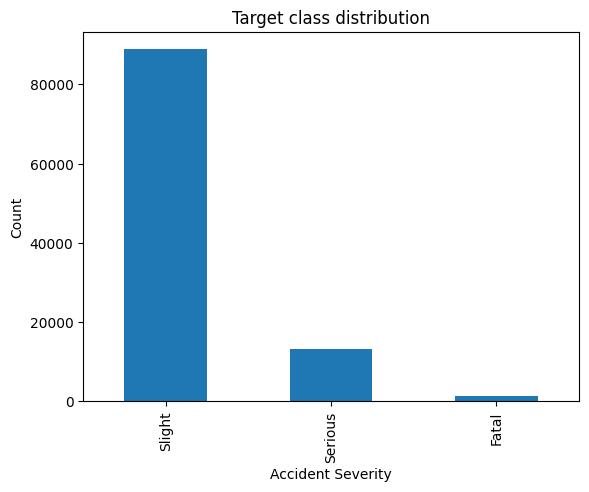

In [13]:
df[target_variable].value_counts().plot.bar()
plt.title('Target class distribution')
plt.xlabel('Accident Severity')
plt.ylabel('Count')
plt.show()

## Data preprocessing
First, we perform preprocessing steps that only improve the DataFrame usability without introducing leakage.

### Separate the target class from attributes. We also don't want Accident_Index

In [14]:
X, y = df.loc[:, df.columns != target_variable], df[target_variable]
del df
gc.collect()

11428

### Consolidate string values Unknown/Unclassified to NaN

In [15]:
X = X.replace(
    [
        "Not known",
        "Data missing or out of range",
        "Unclassified"
    ],
    np.nan)

### Parse Date and Time

In [16]:
X['Date_Time'] = pd.to_datetime(X['Date'] + ' ' + X['Time'].fillna(''), format='mixed')
X['day'] = X['Date_Time'].dt.day
X['month'] = X['Date_Time'].dt.month
X['year'] = X['Date_Time'].dt.year
X['hour'] = X['Date_Time'].dt.hour
X['minute'] = X['Date_Time'].dt.minute

### Drop pointless string columns

In [17]:
X = X.drop(columns=['Accident_Index', 'Date', 'Time'])

### Downcast numeric types

In [18]:
ncols = X.select_dtypes(include='number').columns
X[ncols] = X[ncols] \
    .apply(pd.to_numeric, downcast='float') \
    .apply(pd.to_numeric, downcast='integer') \
    .apply(pd.to_numeric, downcast='unsigned')

### Convert objects to categories

In [19]:
ocols = X.select_dtypes(include='object').columns
X[ocols] = X[ocols].astype('category')

### Check the new types and measure memory usage
From 250 MB to 15 MB. That will help with the further processing

In [20]:
X.info(memory_usage='deep', show_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103463 entries, 0 to 103462
Data columns (total 59 columns):
 #   Column                                       Dtype         
---  ------                                       -----         
 0   1st_Road_Class                               category      
 1   1st_Road_Number                              uint16        
 2   2nd_Road_Class                               category      
 3   2nd_Road_Number                              float32       
 4   Carriageway_Hazards                          category      
 5   Day_of_Week                                  category      
 6   Did_Police_Officer_Attend_Scene_of_Accident  float32       
 7   Junction_Control                             category      
 8   Junction_Detail                              category      
 9   Latitude                                     float32       
 10  Light_Conditions                             category      
 11  Local_Authority_(District)             

### Train-test split
Our train-test ratio is 80:20. We make use of stratification because the target classes are imbalanced.

In [21]:
from sklearn.model_selection import train_test_split

# stratifying preserves the proportion of how data is distributed in the target 
# same proportion of distribution in the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)
del X
del y

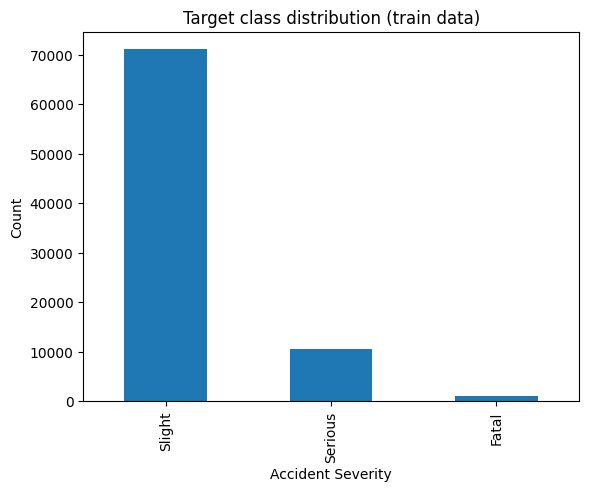

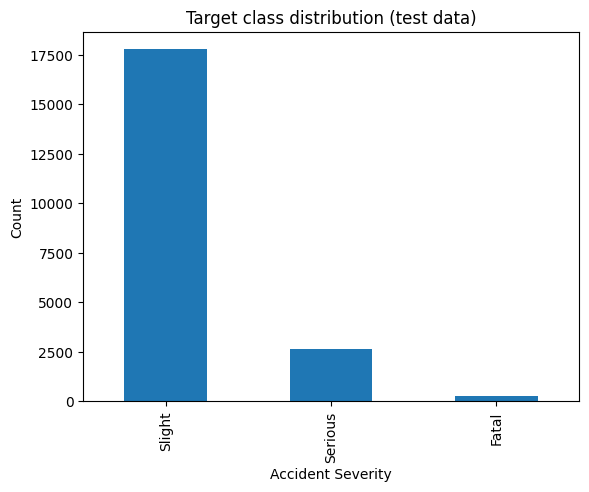

In [22]:
y_train.value_counts().plot.bar()
plt.title('Target class distribution (train data)')
plt.xlabel('Accident Severity')
plt.ylabel('Count')
plt.show()

y_test.value_counts().plot.bar()
plt.title('Target class distribution (test data)')
plt.xlabel('Accident Severity')
plt.ylabel('Count')
plt.show()

### Drop columns with too many missing values
The columns are identified on the train set, the drop is then applied to the test set too

In [23]:
# Get percentage of NaN values for each column
na_percentage = X_train.isna().mean() * 100
na_percentage.sort_values(ascending=False, inplace=True)
na_percentage

Carriageway_Hazards                           98.277
Special_Conditions_at_Site                    97.395
Hit_Object_in_Carriageway                     96.034
Hit_Object_off_Carriageway                    91.334
Skidding_and_Overturning                      87.477
2nd_Road_Class                                80.259
Journey_Purpose_of_Driver                     41.217
Junction_Control                              36.401
Driver_IMD_Decile                             33.411
1st_Road_Class                                26.193
Age_of_Vehicle                                16.388
Driver_Home_Area_Type                         14.702
model                                         14.481
Engine_Capacity_.CC.                          12.030
Propulsion_Code                               11.261
Age_Band_of_Driver                             7.959
LSOA_of_Accident_Location                      6.670
make                                           5.254
Sex_of_Driver                                 

In [24]:
to_drop = na_percentage[na_percentage > 40]
to_drop

Carriageway_Hazards          98.277
Special_Conditions_at_Site   97.395
Hit_Object_in_Carriageway    96.034
Hit_Object_off_Carriageway   91.334
Skidding_and_Overturning     87.477
2nd_Road_Class               80.259
Journey_Purpose_of_Driver    41.217
dtype: float64

In [25]:
X_train.drop(columns=to_drop.index, inplace=True)
X_test.drop(columns=to_drop.index, inplace=True)

### Transformers

In [26]:
numerical_variables = [
    # 'Number_of_Casualties', # Leaks info about accident severity
    # 'Number_of_Vehicles', # Leaks info about accident severity
    'Speed_limit',
    'Age_of_Vehicle',
    'Engine_Capacity_.CC.',
]

nominal_variables = [
    'Day_of_Week',
    'month',
    'hour',
    # 'Carriageway_Hazards',  Too many missing values
    'Junction_Detail',
    'Pedestrian_Crossing-Human_Control',
    'Pedestrian_Crossing-Physical_Facilities',
    'Road_Type',
    # 'Special_Conditions_at_Site', Too many missing values
    'Urban_or_Rural_Area',
    'Weather_Conditions',
    'Driver_Home_Area_Type',
    # 'Hit_Object_in_Carriageway', Too many missing values
    # 'Hit_Object_off_Carriageway', Too many missing values
    'Junction_Location',
    'make',
    'Propulsion_Code',
    'Sex_of_Driver',
    # 'Skidding_and_Overturning', Too many missing values
    'Towing_and_Articulation',
    'Vehicle_Leaving_Carriageway',
    'Vehicle_Location.Restricted_Lane',
    'Vehicle_Manoeuvre',
    'Vehicle_Type',
    'Was_Vehicle_Left_Hand_Drive',
    'X1st_Point_of_Impact',
]

# Order of the values can be determined lexicographically
ordinal_variables_auto = [
    'Age_Band_of_Driver',
    'Driver_IMD_Decile',
]

In [27]:
# Correct order must be set manually
ordinal_variables_manual = [
    '1st_Road_Class',
    'Junction_Control',
    'Light_Conditions',
    'Road_Surface_Conditions',
]

road_class_categories = ['Motorway', 'A(M)', 'A', 'B', 'C']

junction_control_categories = [
    'Not at junction or within 20 metres',
    'Authorised person',
    'Auto traffic signal',
    'Stop sign',
    'Give way or uncontrolled',
]

light_conditions_categories = [
    'Daylight',
    'Darkness - lights lit',
    'Darkness - lighting unknown',
    'Darkness - lights unlit',
    'Darkness - no lighting',
]

road_surface_conditions_categories = [
    'Dry',
    'Wet or damp',
    'Snow',
    'Frost or ice',
    'Flood over 3cm. deep',
]

manual_categories = [
    road_class_categories,
    junction_control_categories,
    light_conditions_categories,
    road_surface_conditions_categories,
]

In [28]:
X_train.filter(nominal_variables + ordinal_variables_auto + ordinal_variables_manual).nunique()

Day_of_Week                                  7
month                                       12
hour                                        24
Junction_Detail                              9
Pedestrian_Crossing-Human_Control            3
Pedestrian_Crossing-Physical_Facilities      6
Road_Type                                    6
Urban_or_Rural_Area                          3
Weather_Conditions                           9
Driver_Home_Area_Type                        3
Junction_Location                            9
make                                       295
Propulsion_Code                             10
Sex_of_Driver                                2
Towing_and_Articulation                      6
Vehicle_Leaving_Carriageway                  9
Vehicle_Location.Restricted_Lane            10
Vehicle_Manoeuvre                           18
Vehicle_Type                                20
Was_Vehicle_Left_Hand_Drive                  2
X1st_Point_of_Impact                         5
Age_Band_of_D

In [29]:
X_train.filter(nominal_variables + ordinal_variables_auto + ordinal_variables_manual).isna().sum(axis=0)

Day_of_Week                                    0
month                                          0
hour                                           0
Junction_Detail                                4
Pedestrian_Crossing-Human_Control             23
Pedestrian_Crossing-Physical_Facilities       49
Road_Type                                      0
Urban_or_Rural_Area                            0
Weather_Conditions                             6
Driver_Home_Area_Type                      12169
Junction_Location                            142
make                                        4349
Propulsion_Code                             9321
Sex_of_Driver                               2908
Towing_and_Articulation                       43
Vehicle_Leaving_Carriageway                   53
Vehicle_Location.Restricted_Lane              48
Vehicle_Manoeuvre                             51
Vehicle_Type                                   9
Was_Vehicle_Left_Hand_Drive                  381
X1st_Point_of_Impact

In [30]:
from sklearn.compose import ColumnTransformer  # applies transformers to columns
from sklearn.pipeline import Pipeline  # assemble several steps
from sklearn.impute import SimpleImputer  # replace missing values using a descriptive statistic (e.g. mean, median,...)
from sklearn.preprocessing import OrdinalEncoder  # encode categorical features as an integer array
from sklearn.preprocessing import OneHotEncoder  # encode categorical features as a one-hot numeric array
from sklearn.preprocessing import StandardScaler  # standardize features by removing the mean and scaling to unit variance

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

ord_pipe_auto = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder()),
])

ord_pipe_manual = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder(categories=manual_categories)),
])

transformers_list = [
    ('numerical', num_pipe, numerical_variables),
    ('nominal', cat_pipe, nominal_variables),
    ('ordinal_auto', ord_pipe_auto, ordinal_variables_auto),
    ('ordinal_manual', ord_pipe_manual, ordinal_variables_manual),
]

column_transformer = ColumnTransformer(
    transformers_list,
    remainder='drop',
    verbose_feature_names_out=False, # If True, ColumnTransformer.get_feature_names_out will prefix all feature names with the name of the transformer that generated that feature.
    verbose=False
)

### Encode labels

In [31]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
label_encoder.classes_

array(['Fatal', 'Serious', 'Slight'], dtype=object)

### Initialize feature selector

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest

feature_selection = SelectKBest(k=50)

## Modeling

### Dummy Classifiers

In [33]:
from sklearn.dummy import DummyClassifier

dummy_clf_stratified = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_clf_stratified.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='stratified')

In [34]:
dummy_clf_mostfrequent = DummyClassifier(strategy='most_frequent')
dummy_clf_mostfrequent.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid_regression = {
    'clf__C': (0.01, 0.1, 1),
}

classification_pipeline_regression = Pipeline([
    ('prep', column_transformer),
    ('select', feature_selection),
    ('clf', LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial', class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE)),
])

search_f1_regression = GridSearchCV(
    estimator=classification_pipeline_regression,
    param_grid=param_grid_regression,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

_ = search_f1_regression.fit(X_train, y_train)

In [36]:
search_f1_regression.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Speed_limit',
                                                   'Age_of_Vehicle',
                                                   'Engine_Capacity_.CC.']),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))])...
                                                                                               'damp',
                                                                                               'Snow',
                                                                                               'Frost '
                                                                                               'or '
                                                                                               'ice',
                                                                                               'Flood '
                                                                                               'over '
                                                                                               '3cm. '
                                                                                               'deep']]))]),
                                                  ['1st_Road_Class',
                                                   'Junction_Control',
                                                   'Light_Conditions',
                                                   'Road_Surface_Conditions'])],
                                   verbose_feature_names_out=False)),
                ('select', SelectKBest(k=50)),
                ('clf',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000, multi_class='multinomial',
                                    n_jobs=-1, random_state=42,
                                    solver='saga'))])

In [37]:
search_f1_regression.best_score_

0.34055382943464213

### Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

param_grid_forest = {
    'clf__max_depth': (10, 20),
    'clf__min_samples_split': (2, 4, 8),
}

classification_pipeline_forest = Pipeline([
    ('prep', column_transformer),
    ('clf', RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE)),
])

search_f1_forest = GridSearchCV(
    estimator=classification_pipeline_forest,
    param_grid=param_grid_forest,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

_ = search_f1_forest.fit(X_train, y_train)

In [39]:
search_f1_forest.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Speed_limit',
                                                   'Age_of_Vehicle',
                                                   'Engine_Capacity_.CC.']),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))])...
                                                                                               'unlit',
                                                                                               'Darkness '
                                                                                               '- '
                                                                                               'no '
                                                                                               'lighting'],
                                                                                              ['Dry',
                                                                                               'Wet '
                                                                                               'or '
                                                                                               'damp',
                                                                                               'Snow',
                                                                                               'Frost '
                                                                                               'or '
                                                                                               'ice',
                                                                                               'Flood '
                                                                                               'over '
                                                                                               '3cm. '
                                                                                               'deep']]))]),
                                                  ['1st_Road_Class',
                                                   'Junction_Control',
                                                   'Light_Conditions',
                                                   'Road_Surface_Conditions'])],
                                   verbose_feature_names_out=False)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        min_samples_split=8, n_jobs=-1,
                                        random_state=42))])

In [41]:
search_f1_forest.best_score_

0.41278336224149187

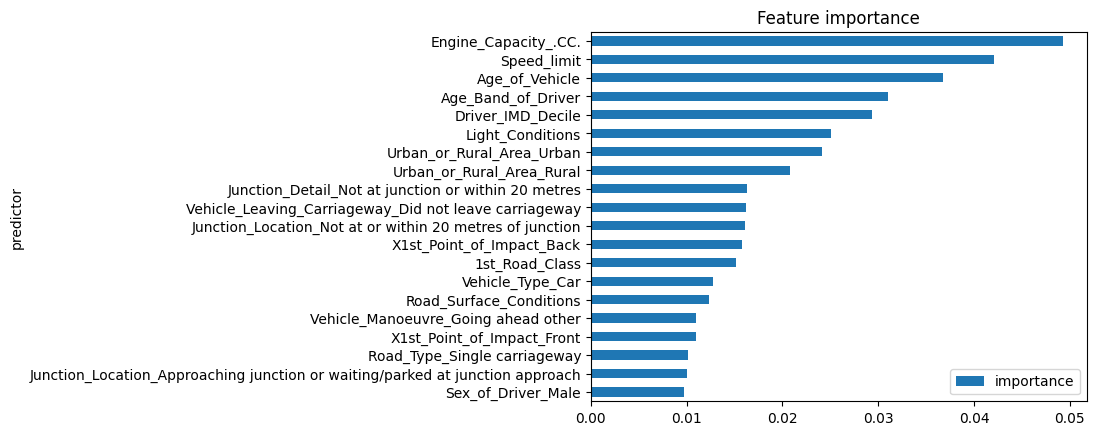

In [42]:
trained_forest_classifier = search_f1_forest.best_estimator_[-1]
data = list(zip(trained_forest_classifier.feature_names_in_ , trained_forest_classifier.feature_importances_))
imp_score_sel = pd.DataFrame(data, columns=['predictor', 'importance']).sort_values(by='importance', ascending=False)
imp_score_sel[19::-1].plot.barh(x='predictor', y='importance')
plt.title('Feature importance')
plt.show()

## Results and Evaluation

In [43]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def print_report(y_test, y_pred):
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
    print(f'Balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}')
    print(classification_report(y_test, y_pred, zero_division=0, target_names=label_encoder.classes_))

def show_confusion_matrices(y_test, y_pred, name: str):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'{name} Confusion Matrices')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs[0], display_labels=label_encoder.classes_)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', ax=axs[1], display_labels=label_encoder.classes_)
    axs[0].set_title('Counts')
    axs[1].set_title('Normalized')
    plt.show()

def show_roc(estimator, X_test, y_test, classes: list, name: str):
    """
    Computes "One-vs-All" (OvA) ROC and Precision-Recall curves
    
    ROC curve is constructed for each class separately by
    treating that class as the positive class and the rest as the negative class. 
    This results in multiple ROC curves, one for each class.

    Precision-Recall curves are plotted separately, because
    each class has a different baseline due to their imbalance.
    :param estimator: 
    :param X_test: 
    :param y_test: 
    :param classes: 
    :param name: 
    :return: 
    """
    
    # Compute class probabilities for the test set
    y_proba = estimator.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(estimator.classes_)):
        fpr[i], tpr[i], _ = roc_curve((y_test == estimator.classes_[i]).astype(int), y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(estimator.classes_)):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.5)  # Plot the diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} One-vs-All ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Compute Precision-Recall curves
    fig, axs = plt.subplots(1, len(label_encoder.classes_), figsize=(18, 5), sharey=True)
    fig.suptitle(f'{name} Precision-Recall Curves')
    for i, cls in enumerate(label_encoder.classes_):
        y_test_i = y_test == i
        baseline = y_test_i.mean()
        axs[i].plot([0, 1], [baseline, baseline], linestyle='--')
        
        precision, recall, _ = precision_recall_curve(y_test_i, y_proba[:,i])
        auc_score = auc(recall, precision)
        axs[i].plot(recall, precision)
        
        axs[i].set_title(f'{cls} (AUC = {auc_score:.2f})')
        axs[i].set_xlabel('Recall')
        axs[i].set_ylabel('Precision')

### Stratified Dummy Classifiers

In [44]:
y_pred_dummy_stratified = dummy_clf_stratified.predict(X_test)
y_proba_dummy_stratified = dummy_clf_stratified.predict_proba(X_test)

print_report(y_test, y_pred_dummy_stratified)

Accuracy: 0.755
Balanced accuracy: 0.335
              precision    recall  f1-score   support

       Fatal       0.02      0.02      0.02       273
     Serious       0.13      0.13      0.13      2655
      Slight       0.86      0.86      0.86     17765

    accuracy                           0.75     20693
   macro avg       0.34      0.34      0.34     20693
weighted avg       0.75      0.75      0.75     20693



### Most Frequent Dummy Classifier

In [45]:
y_pred_dummy_mostfrequent = dummy_clf_mostfrequent.predict(X_test)
y_proba_dummy_mostfrequent = dummy_clf_mostfrequent.predict_proba(X_test)

print_report(y_test, y_pred_dummy_mostfrequent)

Accuracy: 0.859
Balanced accuracy: 0.333
              precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00       273
     Serious       0.00      0.00      0.00      2655
      Slight       0.86      1.00      0.92     17765

    accuracy                           0.86     20693
   macro avg       0.29      0.33      0.31     20693
weighted avg       0.74      0.86      0.79     20693



### Logistic Regression

In [46]:
y_pred_regression = search_f1_regression.predict(X_test)

print_report(y_test, y_pred_regression)

Accuracy: 0.576
Balanced accuracy: 0.497
              precision    recall  f1-score   support

       Fatal       0.04      0.61      0.07       273
     Serious       0.17      0.26      0.21      2655
      Slight       0.91      0.62      0.74     17765

    accuracy                           0.58     20693
   macro avg       0.37      0.50      0.34     20693
weighted avg       0.80      0.58      0.66     20693



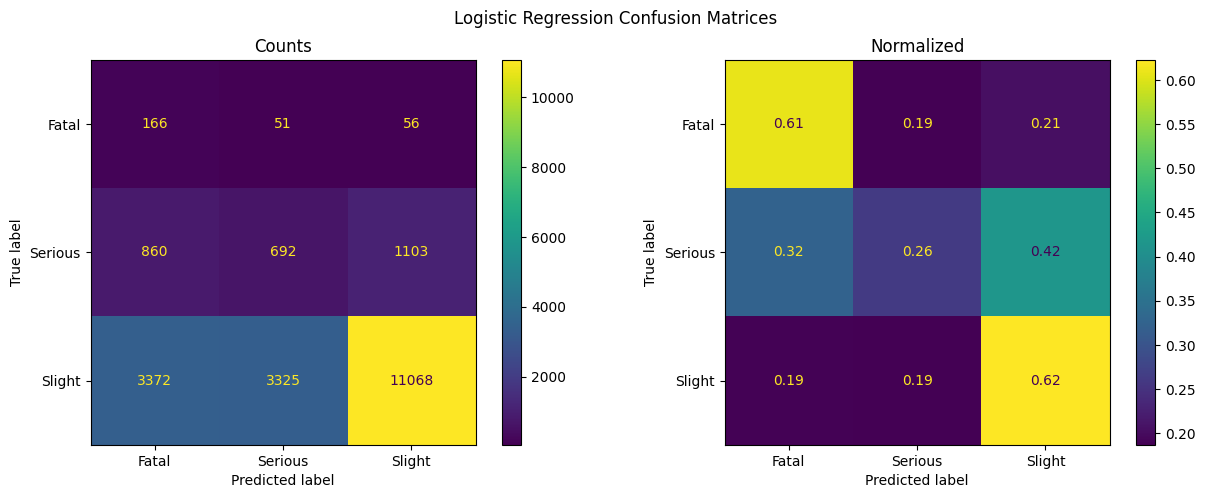

In [47]:
show_confusion_matrices(y_test, y_pred_regression, "Logistic Regression")

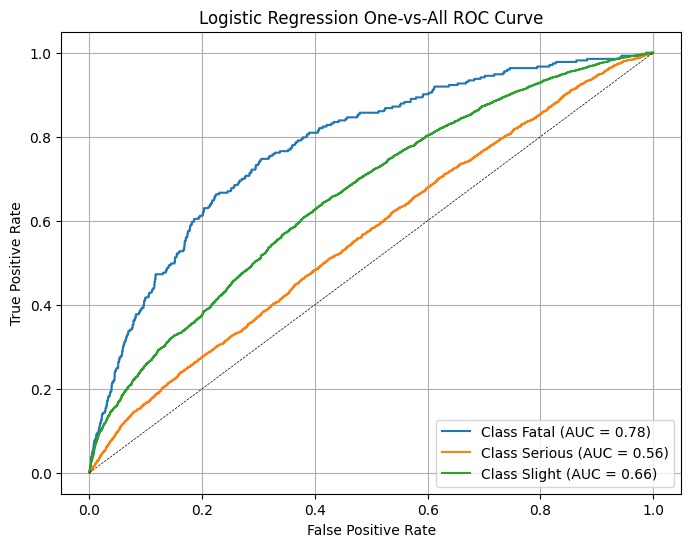

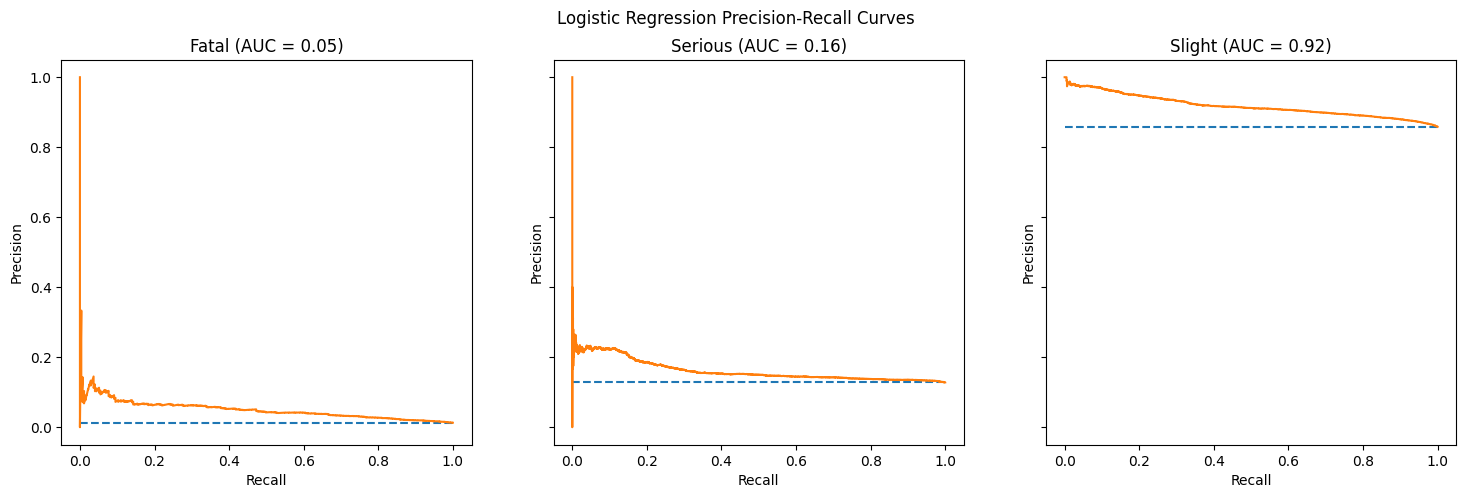

In [48]:
show_roc(search_f1_regression, X_test, y_test, label_encoder.classes_, "Logistic Regression")

### Random Forest

In [49]:
y_pred_forest = search_f1_forest.predict(X_test)

print_report(y_test, y_pred_forest)

Accuracy: 0.787
Balanced accuracy: 0.444
              precision    recall  f1-score   support

       Fatal       0.07      0.25      0.11       273
     Serious       0.27      0.21      0.23      2655
      Slight       0.88      0.88      0.88     17765

    accuracy                           0.79     20693
   macro avg       0.41      0.44      0.41     20693
weighted avg       0.79      0.79      0.79     20693



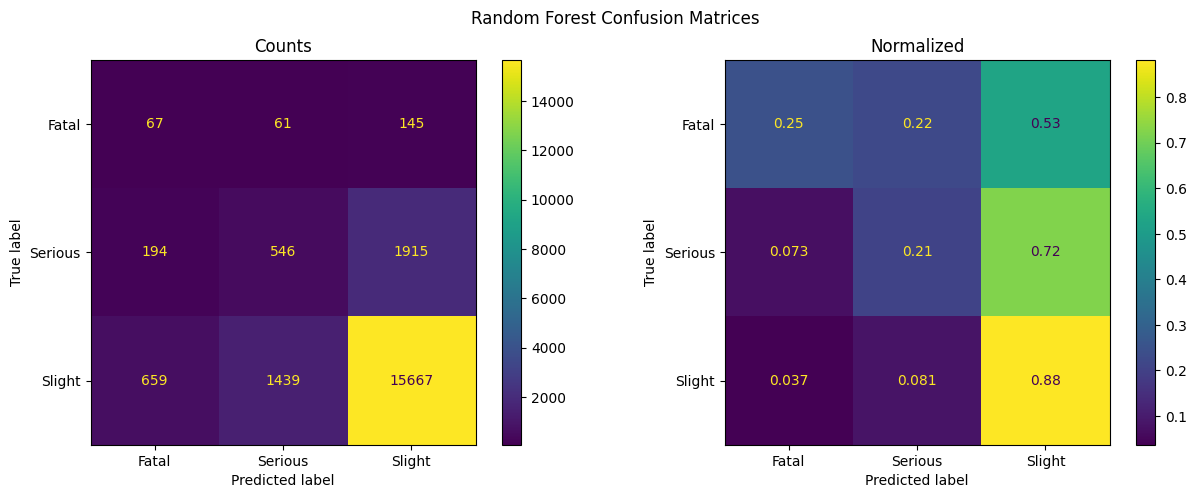

In [50]:
show_confusion_matrices(y_test, y_pred_forest, "Random Forest")

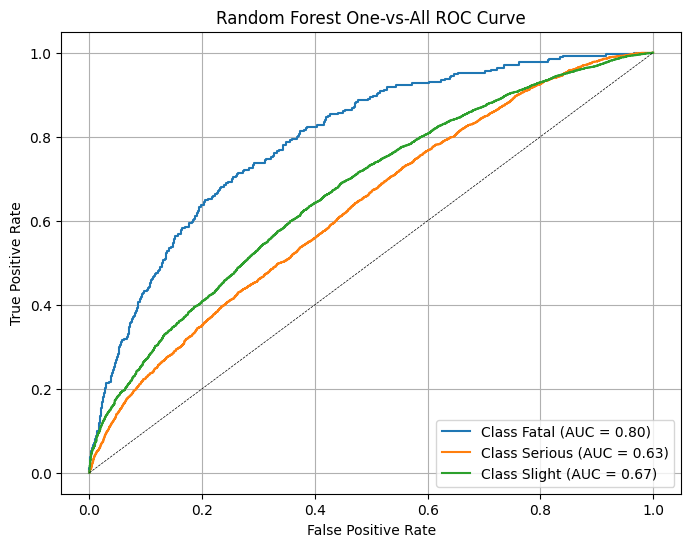

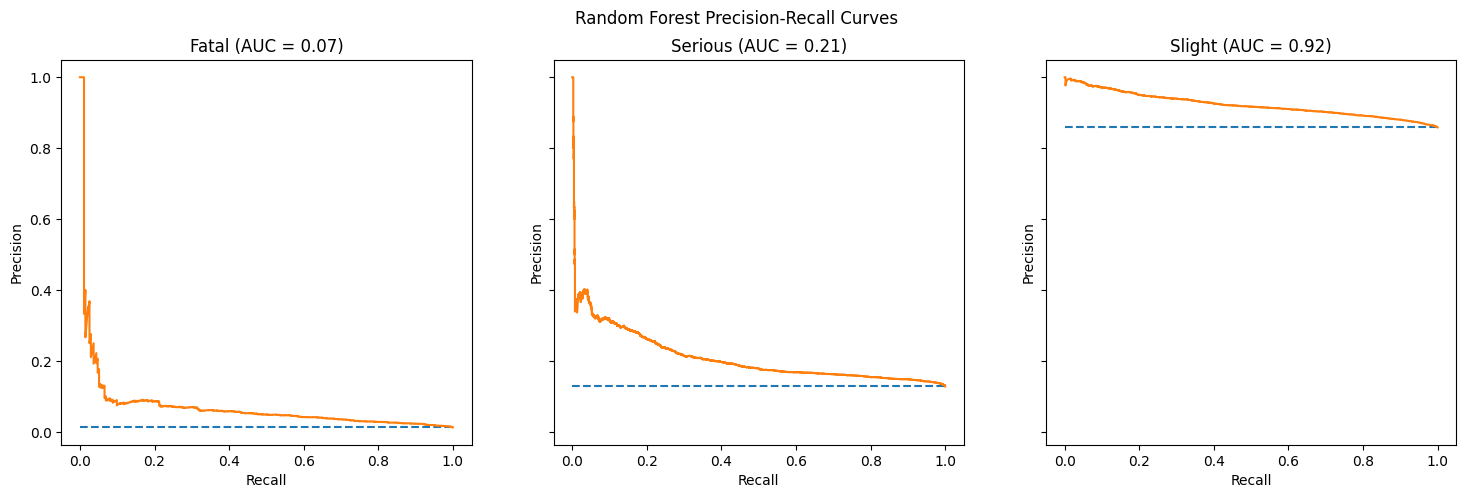

In [51]:
show_roc(search_f1_forest, X_test, y_test, label_encoder.classes_, "Random Forest")

### Conclusion
In this course work we worked with UK Traffic Accidents data.
Our aim was to classify incident severity.

The source dataset is very large. In order to keep computation time on reasonable levels we randomly loaded 0.5% of the dataset.
We split the data to training and testing dataset in proportion 80:20.

We preprocessed the data by:
* merging dataset with accident information and dataset witch vehicle information
* removing variations of expressing missing values in the dataset 
* removing columns where more than 40% values were missing
* creating new column with extracted hour in day from time of the accident
* creating new column with extracted day in year from date of the accident
* using pipeline to handle missing values, encode and scale variables 

Then we built modeling pipeline for Logistic Regression and RandomForest.
The the pipeline consists of:
* Feature selection with Recursive Feature Elimination based on decision tree
* Hyper-parameter tuning and cross-validation using GridSearchCV   
* Training the model

We evaluated the models on their accuracy score and visualised trained model properties using:
*  Confusion Matrix
*  One-vs-All" (OvA) ROC curve

Overall RandomForest had great accuracy of ~0.86.
Logistic Regression model had poor accuracy of ~0.45.
We conclude that the poor performance was caused by the problem complexity and partly by not equal distribution of the target class in the training and test data.  
 